## Compute Sagnac Frequency - Backscatter Correction

## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read
from scipy.signal import hilbert


In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
config = {}

config['ring'] = "U"

config['seed'] = "BW.DROMY..FJU"

config['path_to_sds'] = archive_path+"romy_archive/"

config['tbeg'] = UTCDateTime("2023-09-19 00:00")
config['tend'] = UTCDateTime("2023-09-19 01:00")

# config['f_lower_zoomin'], config['f_upper_zoomin'] = 448-10, 448+10

## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

In [4]:
def __load_romy_raw_data(seed, tbeg, tend, path_to_sds):

    from andbro__read_sds import __read_sds
    from obspy import Stream, UTCDateTime


    print(f" -> loading {seed}...")

    try:
        st00 = __read_sds(path_to_sds, seed, tbeg,tend, data_format='MSEED')
    except:
        print(f" -> failed for {seed}")

    st0 = st00.sort()

    for tr in st0:
        tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]

    return st0

## NEW ULLI

In [5]:
# sagn = __load_romy_raw_data("BW.DROMY..FJU", config['tbeg'], config['tend'], config['path_to_sds'])
# mon1 = __load_romy_raw_data("BW.DROMY..F1V", config['tbeg'], config['tend'], config['path_to_sds'])
# mon2 = __load_romy_raw_data("BW.DROMY..F2V", config['tbeg'], config['tend'], config['path_to_sds'])

### Load Local Files

In [6]:
sagn = read(root_path+"Downloads/mseed/DROMY_FJU_2023-09-19.mseed")
mon1 = read(root_path+"Downloads/mseed/DROMY_F1V_2023-09-19.mseed")
mon2 = read(root_path+"Downloads/mseed//DROMY_F2V_2023-09-19.mseed")

# sagn.trim(config['tbeg'], config['tbeg']+1800)
# mon1.trim(config['tbeg'], config['tbeg']+1800)
# mon2.trim(config['tbeg'], config['tbeg']+1800)

for tr in sagn:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]
for tr in mon1:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]
for tr in mon2:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]

config['tbeg'], config['tend'] = sagn[0].stats.starttime, sagn[0].stats.endtime

In [7]:
# sagn.plot();
# mon1.plot();
# mon2.plot();

## Processing

In [8]:
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from acoustics.signal import phase_spectrum
from functions.get_time_intervals import __get_time_intervals

In [9]:
def __get_values(ff, psd, fph, ph, f_sagn, multitaper=False):

    from numpy import argmax, sqrt, where, argmin, gradient, mean
    from acoustics.signal import phase_spectrum

    ## specify f-band around Sagnac frequency
    fl = f_sagn-2
    fu = f_sagn+2

    ## get index of Sagnac peak
    idx_fs = where(psd == max(psd[(ff > fl) & (ff < fu)]))[0][0]

    if multitaper:
        ## compute gradient
        psd_d = abs(gradient(psd))

        ## cut psd below f_sagn -10 Hz and above f_sagn + 10 Hz
        psd_d1 = psd_d[(ff < f_sagn) & (ff > f_sagn - 10)]
        psd_d2 = psd_d[(ff > f_sagn) & (ff < f_sagn + 10)]

        ## get index of maximum gradient
        idx1 = where(psd_d == max(psd_d1))[0][0]
        idx2 = where(psd_d == max(psd_d2))[0][0]

        ## get index in the center of the stronges changes (= center of plateau)
        idx_fs = int( (idx2-idx1) /2 + idx1 )

    ## estimate Sagnac frequency
    f_sagn_est = ff[idx_fs]

    ## estimate AC value at Sagnac peak
    # AC_est = max(psd[(ff > fl) & (ff < fu)])
    AC_est = psd[idx_fs]

    ## estimate DC value at ff = 0
    DC_est = psd[0]

    ## estimate phase at Sagnac peak
    idx_ph = argmin(abs(fph- f_sagn_est)) ## finde index of phase closest to sagnac frequency
    phase_est = ph[idx_ph] ## select phase of Sagnac

    # return f_sagn_est, sqrt(AC_est), sqrt(DC_est), phase_est
    return f_sagn_est, AC_est, DC_est, phase_est

In [10]:
def __get_fft(signal_in, dt, window=None):

    '''
    Calculating a simple 1D FastFourierSpectrum of a time series.

    RETURN:

    frequencies, spectrum, phase

    TEST:

    >>> spectrum, frequencies, phase = __fft(signal_in, dt ,window=None,normalize=None)
    '''

    from scipy.fft import fft, fftfreq, fftshift
    from scipy import signal
    from numpy import angle, imag

    ## determine length of the input time series
    n = int(len(signal_in))


    ## calculate spectrum (with or without window function applied to time series)
    if window is None or window is False:
        spectrum = fft( signal_in )

    elif window == "hanning":
        window = signal.hann(n);
        spectrum = fft(signal_in * window)

    elif window == "kaiser":
        window = signal.kaiser(n, 8.6); print('Kaiser window (beta = 8.6) applied \n')
        #window = signal.gaussian(n, std=20); print('Gaussian window (std = 20) applied \n')
        spectrum = fft( signal_in * window )

    else:
        print("choose either 'hanning' or 'kaiser' as window")

    ## calculate frequency array 
    frequencies = fftfreq(n, d=dt)


    ## correct amplitudes of spectrum
    magnitude = 2.0 / n * abs(spectrum)

    phase = angle(spectrum, deg=False)
    # phase = imag(spectrum)

    ## return the positive frequencies
    return frequencies[0:n//2], magnitude[0:n//2], phase[0:n//2]

In [11]:
def __welch_psd(arr, dt, twin_sec=60):

    from scipy.signal import welch
    from scipy.signal.windows import hann

    nblock = int(1/dt * twin_sec)
    overlap = int(0.5*nblock)
    win = hann(nblock, True)

    ff, Pxx = welch(arr,
                    fs=1/dt,
                    window=win, noverlap=overlap,
                    nfft=nblock,
                    scaling="spectrum",
                    return_onesided=True)

    return ff, Pxx

## Configurations

In [12]:
tbeg, tend = sagn[0].stats.starttime, sagn[0].stats.endtime

interval = 60 ## seconds

method = "fft" ## welch | multitaper | fft

times = __get_time_intervals(tbeg, tend, interval_seconds=interval, interval_overlap=0)

## Computing

In [13]:
fs, ac, dc, ph = np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan


out_df = DataFrame()
out_df['time1'] = list(zip(*times))[0]
out_df['time2'] = list(zip(*times))[1]

for _k, _st in enumerate([sagn, mon1, mon2]):

    print(_k, "...")

    for _n, (t1, t2) in enumerate(times):

        _dat = _st.copy().trim(t1, t2)

        if method == "welch":
            f, psd = __welch_psd(_dat[0].data, _dat[0].stats.delta, twin_sec=interval)
            f_pha, pha = phase_spectrum(_dat[0].data, _dat[0].stats.sampling_rate)
        elif method == "multitaper":
            f, psd = __multitaper_psd(_dat[0].data, _dat[0].stats.delta, n_win=4)
            f_pha, pha = phase_spectrum(_dat[0].data, _dat[0].stats.sampling_rate)
        elif method == "fft":
            f, psd, pha = __get_fft(_dat[0].data, _dat[0].stats.delta)
            f_pha = f
            psd = psd**2

        if method == "multitaper":
            fs[_n], ac[_n], dc[_n], ph[_n] = __get_values(f, psd, f_pha, pha, 303, multitaper=True)
        else:
            fs[_n], ac[_n], dc[_n], ph[_n] = __get_values(f, psd, f_pha, pha, 303)

        # dc[_n] = np.mean(_dat)
        # ac[_n] = np.percentile(_dat[0].data, 99.9) - np.percentile(_dat[0].data, 100-99.9)

    ph = np.unwrap(ph)

    if _k == 0:
        out_df['fj_fs'], out_df['fj_ac'], out_df['fj_dc'], out_df['fj_ph'] = fs, ac, dc, ph
    elif _k == 1:
        out_df['f1_fs'], out_df['f1_ac'], out_df['f1_dc'], out_df['f1_ph'] = fs, ac, dc, ph
    elif _k == 2:
        out_df['f2_fs'], out_df['f2_ac'], out_df['f2_dc'], out_df['f2_ph'] = fs, ac, dc, ph

## store data
date_str = f"{config['tbeg'].year}{str(config['tbeg'].month).rjust(2,'0')}{str(config['tbeg'].day).rjust(2,'0')}"
out_df.to_pickle(config['path_to_data']+f"{date_str}_{method}.pkl")

0 ...
1 ...
2 ...


In [14]:
out_df

,time1,time2,fj_fs,fj_ac,fj_dc,fj_ph,f1_fs,f1_ac,f1_dc,f1_ph,f2_fs,f2_ac,f2_dc,f2_ph
0,2023-09-19T00:00:00.000000Z,2023-09-19T00:01:00.000000Z,303.065656,0.005362,0.038379,0.197328,303.065656,0.000045,0.695874,2.797403,303.065656,0.000009,0.664249,-1.908576
1,2023-09-19T00:01:00.000000Z,2023-09-19T00:02:00.000000Z,303.065656,0.005591,0.038497,-2.089324,303.065656,0.000047,0.696036,0.464413,303.065656,0.000009,0.663649,-4.245801
2,2023-09-19T00:02:00.000000Z,2023-09-19T00:03:00.000000Z,303.065656,0.005643,0.038484,-4.332173,303.065656,0.000047,0.695960,-1.812212,303.065656,0.000009,0.664174,-6.525569
3,2023-09-19T00:03:00.000000Z,2023-09-19T00:04:00.000000Z,303.065656,0.005325,0.038550,-6.668228,303.065656,0.000044,0.695903,-4.195280,303.065656,0.000009,0.665815,-8.905413
4,2023-09-19T00:04:00.000000Z,2023-09-19T00:05:00.000000Z,303.065656,0.005329,0.038565,-9.025958,303.065656,0.000044,0.696088,-6.599382,303.065656,0.000009,0.665521,-11.309047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2023-09-19T01:55:00.000000Z,2023-09-19T01:56:00.000000Z,303.048990,0.006996,0.040959,-78.954564,303.048990,0.000064,0.702320,-69.923165,303.048990,0.000009,0.714414,-74.544188
116,2023-09-19T01:56:00.000000Z,2023-09-19T01:57:00.000000Z,303.048990,0.006799,0.040937,-78.085531,303.048990,0.000062,0.702674,-69.106542,303.048990,0.000009,0.713356,-73.721011
117,2023-09-19T01:57:00.000000Z,2023-09-19T01:58:00.000000Z,303.048990,0.007004,0.040975,-77.250280,303.048990,0.000064,0.702636,-68.287023,303.048990,0.000009,0.714300,-72.904152
118,2023-09-19T01:58:00.000000Z,2023-09-19T01:59:00.000000Z,303.048990,0.006671,0.040972,-76.351042,303.048990,0.000061,0.702773,-67.424829,303.048990,0.000008,0.713790,-72.047172


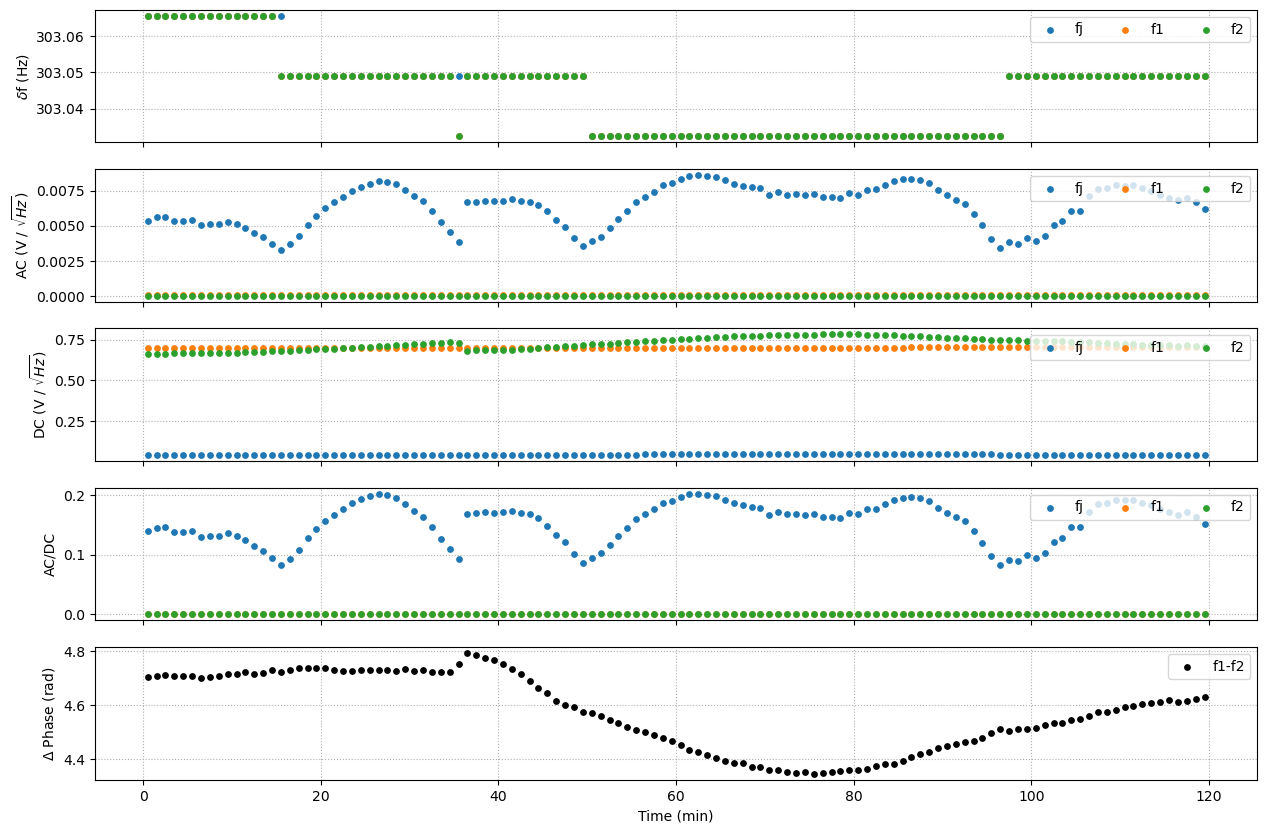

In [15]:
def __makeplot(df):

    Nrow, Ncol = 5, 1

    font = 12
    ms = 15

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    t_axis = (np.array(range(len(df['fj_fs'])))+0.5)*interval/60

    ax[0].scatter(t_axis, df['fj_fs'], zorder=2, s=ms, label="fj")
    ax[0].scatter(t_axis, df['f1_fs'], zorder=2, s=ms, label="f1")
    ax[0].scatter(t_axis, df['f2_fs'], zorder=2, s=ms, label="f2")
    ax[0].set_ylabel("$\delta$f (Hz)")
    ax[0].ticklabel_format(useOffset=False)

    ax[1].scatter(t_axis, df['fj_ac'], zorder=2, s=ms, label="fj")
    ax[1].scatter(t_axis, df['f1_ac'], zorder=2, s=ms, label="f1")
    ax[1].scatter(t_axis, df['f2_ac'], zorder=2, s=ms, label="f2")
    ax[1].set_ylabel("AC (V / $\sqrt{Hz})$")

    ax[2].scatter(t_axis, df['fj_dc'], zorder=2, s=ms, label="fj")
    ax[2].scatter(t_axis, df['f1_dc'], zorder=2, s=ms, label="f1")
    ax[2].scatter(t_axis, df['f2_dc'], zorder=2, s=ms, label="f2")
    ax[2].set_ylabel("DC (V / $\sqrt{Hz})$")
    # ax[2].set_yscale("log")

    ax[3].scatter(t_axis, df['fj_ac']/df['fj_dc'], zorder=2, s=ms, label="fj")
    ax[3].scatter(t_axis, df['f1_ac']/df['f1_dc'], zorder=2, s=ms, label="f1")
    ax[3].scatter(t_axis, df['f2_ac']/df['f2_dc'], zorder=2, s=ms, label="f2")
    # ax[3].set_yscale("log")
    ax[3].set_ylabel("AC/DC")

    ax[4].scatter(t_axis, df['f1_ph']-df['f2_ph'], color="k", zorder=2, s=ms, label="f1-f2")
    ax[4].set_ylabel("$\Delta$ Phase (rad)")
    # ax[4].set_yscale("log")

    ax[4].set_xlabel("Time (min)")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, ncol=3)

    plt.show();
    return fig

fig = __makeplot(out_df);

fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_{method}_values_10hr.jpeg", format="jpeg", dpi=200, bbox_inches='tight')

## Define Quantities for Backscatter Correction

In [16]:
# fractional beat modulations
m01 = out_df.f1_ac / out_df.f1_dc
m02 = out_df.f2_ac / out_df.f2_dc


# phase difference
# phase0 = abs(hilbert(beat.f1 - beat.f2))
# phase0 = abs(out_df.f1_ph - out_df.f2_ph)
phase0 = out_df.f1_ph - out_df.f2_ph

# beat signal observed
w_obs = out_df.fj_fs


## from Hurst 2014

cm_filter_factor = 1.033

## free spectral range fsr = c / P
fL = 8e6 ## Hz

## gain
alpha = 7.39e-6

## sekf-saturation coefficient
beta = 4.67e-5

## cross-saturation coefficient
theta = 1.014e-5

# I0 =

## Compute Backscatter Correction

In [17]:
## Correct for bias
m1 = m01 * ( 1 + m01**2 / 4 )
m2 = m02 * ( 1 + m02**2 / 4 )

## angular correction for phase
phase = phase0 + 0.5 * m1 * m2 * np.sin( phase0 )

## compute squares of common-mode modulations
m2c = ( m1**2 + m2**2 + 2*m1*m2*np.cos( phase ) ) / 4

## compute squares of differential-mode modulations
m2d = ( m1**2 + m2**2 - 2*m1*m2*np.cos( phase ) ) / 4  ## different angle!

## correct m2c for gain saturation of a HeNe laser
# m2c = m2c * ( 1 + ( beta + theta )**2 * fL**2 * I0**2 / ws**2 )
m2c = m2c * cm_filter_factor

## compute backscatter correction factor
M = m2c - m2d + 0.25 * m1**2 * m2**2 * np.sin(phase)**2

## Beat Data

In [18]:
def __load_beat(tbeg, tend, ring, path_to_data):

    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range
    from obspy import UTCDateTime


    tbeg, tend = UTCDateTime(tbeg), UTCDateTime(tend)

    dd1 = date.fromisoformat(str(tbeg.date))
    dd2 = date.fromisoformat(str(tend.date))

    year = str(tbeg.year)

    df = DataFrame()
    for dat in date_range(dd1, dd2):
        file = f"{year}/R{ring}/FJ{ring}_"+str(dat)[:10].replace("-", "")+".pkl"
        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")

    ## trim to defined times
    df = df[(df.times_utc >= tbeg) & (df.times_utc < tend)]

    ## correct seconds
    df['times_utc_sec'] = [abs(tbeg - UTCDateTime(_t))  for _t in df['times_utc']]

    return df

In [19]:
data = __load_beat(config['tbeg'], config['tend'], config['seed'].split(".")[3][2], config['path_to_autodata'])
w_obs = data['fj']

## Correct Beat for Backscatter

In [20]:
len(w_obs), len(M)

(120, 120)

In [21]:
w_s = np.array(w_obs) * ( 4 + M ) / ( 4 - M )

## Plotting

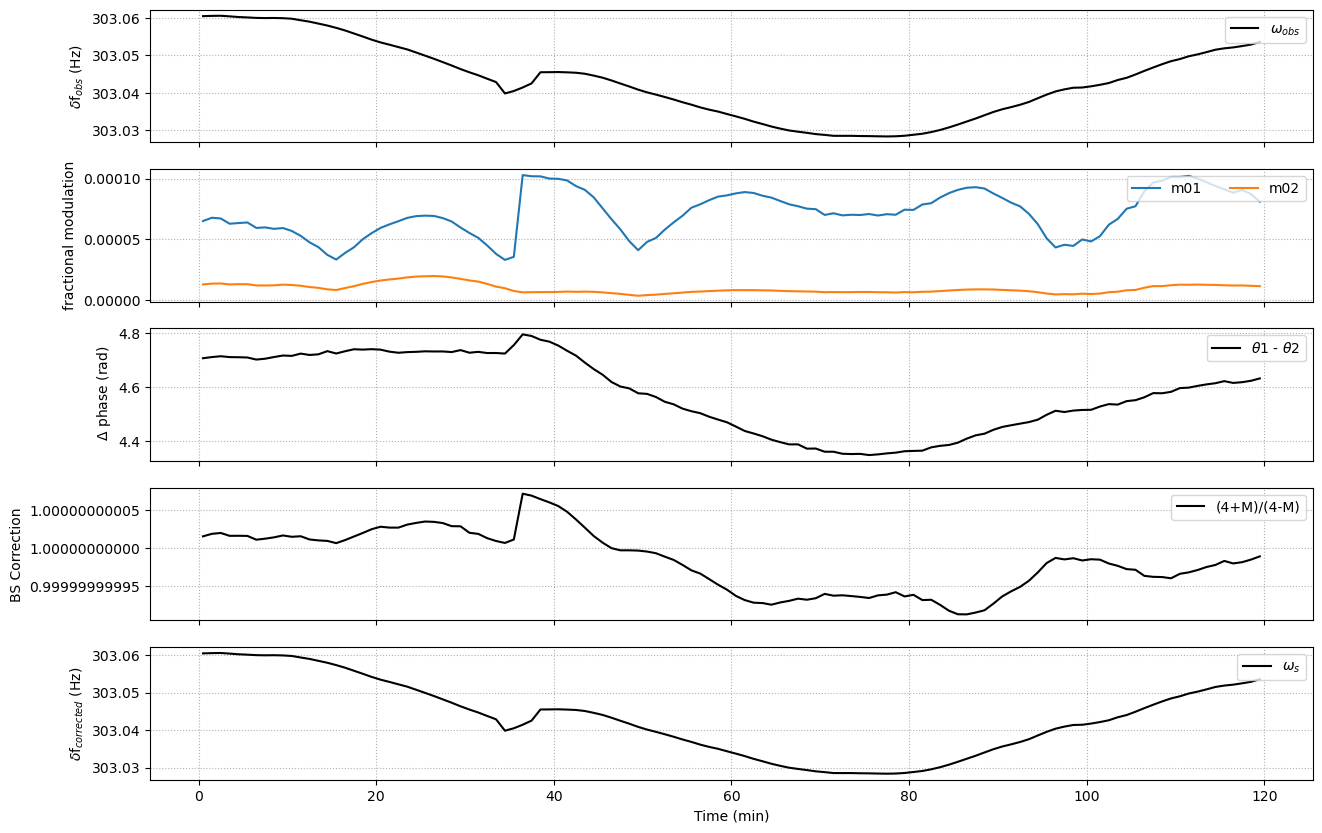

In [22]:
def __makeplot():

    Nrow, Ncol = 5, 1

    font = 12
    ms = 15

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    t_axis = (np.array(range(len(out_df['fj_fs'])))+0.5)*interval/60

    ax[0].plot(t_axis, w_obs, color="k", label="$\omega_{obs}$")
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\delta$f$_{obs}$ (Hz)")

    ax[1].plot(t_axis, m01, label="m01")
    ax[1].plot(t_axis, m02, label="m02")
    ax[1].set_ylabel("fractional modulation")

    ax[2].plot(t_axis, phase, color="k", label=r"$\theta$1 - $\theta$2")
    ax[2].set_ylabel(" $\Delta$ phase (rad)")

    # ax[3].plot(t_axis, M, color="k", label="M")
    ax[3].plot(t_axis, (4+M)/(4-M), color="k", label="(4+M)/(4-M)")
    ax[3].set_ylabel("BS Correction")
    ax[3].ticklabel_format(useOffset=False)

    ax[4].plot(t_axis, w_s, color="k", label="$\omega_{s}$")
    ax[4].set_ylabel("$\delta$f$_{corrected}$ (Hz)")
    ax[4].ticklabel_format(useOffset=False)

    ax[4].set_xlabel("Time (min)")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, ncol=3)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_frequencyomain_{method}_{interval}.png", format="png", dpi=200, bbox_inches='tight')

0.042391419570450894


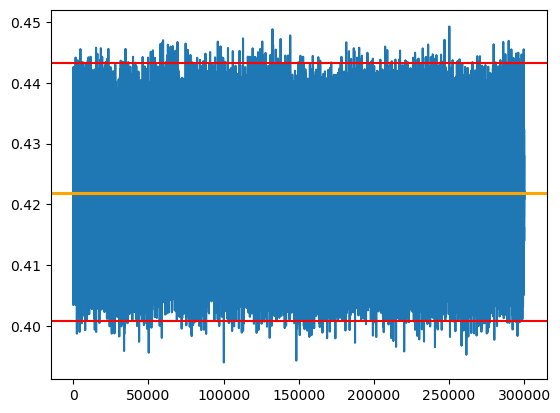

In [23]:
ac1 = np.percentile(_dat[0].data, 99.9)
ac2 = np.percentile(_dat[0].data, 100-99.9)

print(ac1-ac2)

plt.plot(_dat[0].data)
plt.axhline(ac1, c="r", zorder=2)
plt.axhline(ac2, c="r", zorder=2)
plt.axhline(np.mean(_dat[0].data), c="orange", zorder=2)
plt.axhline(np.median(_dat[0].data), c="orange", zorder=2)

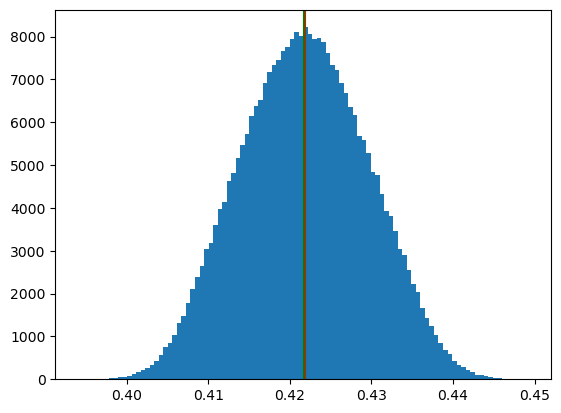

In [24]:
plt.hist(_dat[0].data, bins=100)
plt.axvline(np.mean(_dat[0].data), color='r')
plt.axvline(np.median(_dat[0].data), color='g')
plt.show();